In [8]:
FOLDER_NAME = "Posts/"

In [9]:
# Extracting files from JSON

import os
import json

countF = 0
countI = 0

InstaPostList = []

for folder in os.listdir(FOLDER_NAME):
    if folder==".ipynb_checkpoints":
        continue
    foldername = FOLDER_NAME + folder
    for file in os.listdir(foldername):
        if file==".ipynb_checkpoints":
            continue
        with open(foldername+"/"+file, "r") as f:
            posts = f.readlines()
            for post in posts:
                post = json.loads(post)
                for postF in post['result']['posts']:
                    if postF['platform']=="Facebook":
                        InstaPostList.append(postF)

In [10]:
# Removing duplicate posts

IdDict = set()
newList = []

for post in InstaPostList:
    if post['platformId'] in IdDict:
        continue
    else:
        newList.append(post)
        IdDict.add(post['platformId'])

InstaPostList = newList

In [11]:
# Monthly Post analysis
from datetime import datetime

MonthlyPost = dict()

for post in InstaPostList:
    month = datetime.strptime(post['date'], "%Y-%m-%d %H:%M:%S")
    month = "{}-{}-01".format(month.year, month.month)
    if month in MonthlyPost:
        MonthlyPost[month] += 1
    else:
        MonthlyPost[month] = 0

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

<AxesSubplot:xlabel='Month', ylabel='Number of Posts'>

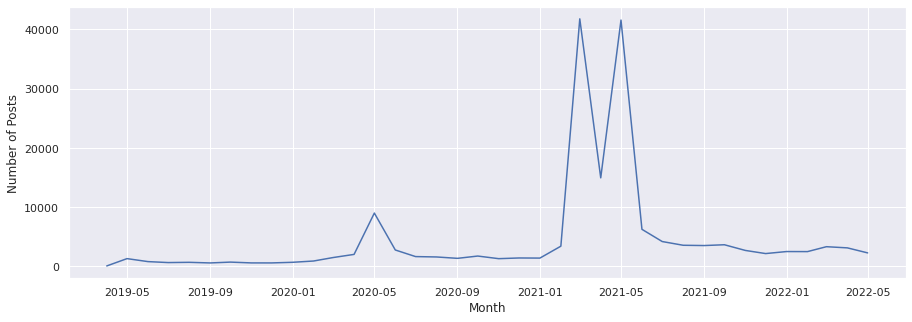

In [13]:
MonthlyPostDF = pd.DataFrame({
    "Month" : [datetime.strptime(date, "%Y-%m-%d") for date in MonthlyPost.keys()],
    "Number of Posts" : [val for val in MonthlyPost.values()]
})
plt.figure(figsize = (15,5))
sns.lineplot(x="Month", y="Number of Posts", data=MonthlyPostDF)

In [18]:
# Popular accounts/pages

Accounts = dict()

for post in InstaPostList:
    if post['account']['name'] not in Accounts.keys():
        Accounts[post['account']['name']] = {
            "subscriberCount" : post['account']['subscriberCount'],
            "postCount" : 0
        }
    Accounts[post['account']['name']]['subscriberCount'] = max(Accounts[post['account']['name']]['subscriberCount'], post['account']['subscriberCount'])
    Accounts[post['account']['name']]['postCount'] += 1

In [19]:
AccountsSubs = {k: v for k, v in sorted(Accounts.items(), key=lambda item: item[1]['subscriberCount'], reverse=True)[:15]}

for accn in AccountsSubs.keys():
    print("Account - {}, Subscriber Count - {}, Post Count - {}".format(accn, AccountsSubs[accn]['subscriberCount'], AccountsSubs[accn]['postCount']))

Account - Facebook App, Subscriber Count - 174219958, Post Count - 12
Account - CGTN, Subscriber Count - 117820250, Post Count - 17
Account - China Daily, Subscriber Count - 103778485, Post Count - 17
Account - Tasty, Subscriber Count - 96770232, Post Count - 9
Account - China Xinhua News, Subscriber Count - 92355026, Post Count - 35
Account - YouTube, Subscriber Count - 86921170, Post Count - 1
Account - People's Daily, China, Subscriber Count - 85500084, Post Count - 2
Account - Netflix, Subscriber Count - 81413604, Post Count - 2
Account - Meta, Subscriber Count - 72548105, Post Count - 4
Account - Global Times, Subscriber Count - 67715747, Post Count - 7
Account - National Geographic TV, Subscriber Count - 64163639, Post Count - 5
Account - Instagram, Subscriber Count - 60826192, Post Count - 4
Account - Disney, Subscriber Count - 52518410, Post Count - 6
Account - National Geographic, Subscriber Count - 46684446, Post Count - 2
Account - CONVERSE, Subscriber Count - 46681315, Post

In [20]:
AccountsPosts = {k: v for k, v in sorted(Accounts.items(), key=lambda item: item[1]['postCount'], reverse=True)[:15]}

for accn in AccountsPosts.keys():
    print("Account - {}, Subscriber Count - {}, Post Count - {}".format(accn, AccountsPosts[accn]['subscriberCount'], AccountsPosts[accn]['postCount']))

Account - Act To Change, Subscriber Count - 1945, Post Count - 1364
Account - Untigering, Subscriber Count - 74549, Post Count - 754
Account - OMG Sportswear Thailand, Subscriber Count - 27179, Post Count - 672
Account - OCA Greater Chicago, Subscriber Count - 776, Post Count - 624
Account - AAAAR - Asian American Alliance Against Racism, Subscriber Count - 4594, Post Count - 571
Account - Proudly Chinese SA, Subscriber Count - 2472, Post Count - 475
Account - AAPI Women Lead, Subscriber Count - 3119, Post Count - 454
Account - Asian Vibes, Subscriber Count - 59818, Post Count - 453
Account - Racism Is A Virus, Subscriber Count - 2386, Post Count - 449
Account - VolunteerMatch, Subscriber Count - 76175, Post Count - 433
Account - Asians in LA, Subscriber Count - 7511, Post Count - 431
Account - Museum of Chinese in America, Subscriber Count - 12864, Post Count - 374
Account - Asian Pacific Fund, Subscriber Count - 1040, Post Count - 351
Account - AARP AAPI Community, Subscriber Count -

In [21]:
# Overall word analysis

from gensim.parsing.preprocessing import remove_stopwords
import re

wordCount = dict()

for post in InstaPostList:
    try:
        text = post['message']
    except:
        try:
            text = post['description']
        except:
            continue 
    text = re.sub(r'http\S+', '', text)
    text = text.replace('\n'," ")
    text = text.replace('\t'," ")
    text = text.lower()
    res = re.sub(r'[^\w\s]', ' ', text)
    res = remove_stopwords(res)
    words = res.split()
    for word in words:
        if(len(word) <= 1):
            continue
        if word not in wordCount.keys():
            wordCount[word] = 0
        wordCount[word] += 1

In [22]:
wordCountSorted = sorted(wordCount, key=wordCount.get, reverse=True)

In [23]:
wordCountSorted[:15]

['asian',
 'aapi',
 'american',
 'community',
 'stopasianhate',
 'hate',
 'pacific',
 'support',
 'month',
 'racism',
 'people',
 'violence',
 'americans',
 'islander',
 'heritage']

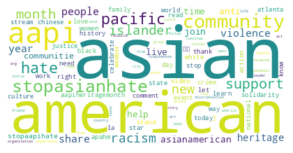

In [25]:
# Word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

txt = ""
for word in wordCount.keys():
    for i in range(wordCount[word]):
        txt += word + " "

plt.figure(figsize = (5,5))
word_cloud = WordCloud(collocations = False, background_color = 'white', max_words=100).generate(txt)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
# Hashtag freuqency
import re

all_hashtags = dict()
hashtag_re = re.compile("#\w+ ")

for post in InstaPostList:
    try:
        line = post['message']
    except:
        try:
            line = post['description']
        except:
            continue 
    try:
        line = line.strip();
        line = line.lower();
    except:
        continue;
    tweet = line;
    hashtags = re.findall(hashtag_re,tweet);
    if(len(hashtags)>0):
        for hashtag in hashtags:
            hashtag = hashtag.strip();
            if(len(hashtag)<3):
                continue;
            if hashtag in all_hashtags.keys():
                all_hashtags[hashtag] += 1
            else:
                all_hashtags[hashtag] = 1

In [27]:
all_hashtags = {k:v for k,v in sorted(all_hashtags.items(), key=lambda item: item[1], reverse=True)}

In [28]:
all_hashtags

{'#stopasianhate': 34503,
 '#aapi': 25221,
 '#asianamerican': 14985,
 '#aapiheritagemonth': 10637,
 '#stopaapihate': 10288,
 '#apahm': 6813,
 '#stopthehate': 5791,
 '#facebookgaming': 5573,
 '#community': 5214,
 '#asian': 4428,
 '#blacklivesmatter': 4357,
 '#support': 3622,
 '#warzone': 3532,
 '#aapihm': 3340,
 '#charity': 3318,
 '#contentcreator': 3291,
 '#streamer': 3269,
 '#h2o': 3258,
 '#asianpacificfund': 3236,
 '#freefire': 3209,
 '#pubg': 3207,
 '#tongchheavkao_vlog': 3206,
 '#b2k': 3206,
 '#mobile_legend': 3206,
 '#live_free_fire': 3206,
 '#covid19': 2925,
 '#racismisavirus': 2697,
 '#asianamericans': 2529,
 '#facebooklive': 2059,
 '#asianheritagemonth': 2042,
 '#chineseamerican': 1920,
 '#racism': 1889,
 '#hateisavirus': 1818,
 '#diversity': 1635,
 '#untigering': 1631,
 '#gentleparenting': 1622,
 '#consciousparenting': 1621,
 '#peacefulparenting': 1620,
 '#asianparenting': 1613,
 '#decolonizingparenting': 1598,
 '#respectfulparenting': 1587,
 '#representationmatters': 1549,
 '

In [29]:
# URL Frequency
URLs = dict()

for post in InstaPostList:
  try:
    post = post['expandedLinks']

    for link in post:
      url = link['original']
      if url not in URLs.keys():
        URLs[url] = 0
      URLs[url] += 1
  except:
    continue

In [30]:
URLs = {k:v for k,v in sorted(URLs.items(), key=lambda item:item[1], reverse=True)}

In [31]:
URLs

{'https://www.facebook.com/becomesupporter/1958198171086239/': 3359,
 'https://www.youtube.com/c/KonPovGaming': 3358,
 'https://discord.gg/WgUKXCvq7H': 3357,
 'https://t.me/kaotongchheav': 3341,
 'https://stopaapihate.org/': 501,
 'www.omgsportswearasia.com': 385,
 'https://anti-asianviolenceresources.carrd.co/': 307,
 'https://www.facebook.com/lakascmdphofficial/videos/1307253186430265/': 275,
 'to.pbs.org/331h3ZB': 252,
 'https://bit.ly/2tjU5Lj': 245,
 'www.skylinktv.us': 229,
 'https://bit.ly/3cJV1xj': 221,
 'https://asianpacificheritage.gov/': 218,
 '👉http://www.youtube.com/LittleJadeWorld': 218,
 'acttochange.org/2021dayagainstbullying': 171,
 'www.instagram.com/Jaydelynrose': 170,
 'www.facebook.com/LittleJadeWorld': 167,
 'https://www.asianamericandayofaction.com/': 156,
 'paparazziaccessories.com/join/314293': 154,
 'Paparazziaccessories.com/314293': 152,
 'postable👇Www.postable.com/christinapacheco': 148,
 'bit.ly/DonateToGeorgiaAAPICommunity': 147,
 'bit.ly/aaajcommunitystate

In [35]:
# Reach analysis
shareCount = []
CommentCount = []
loveCount = []
wowCount = []
hahaCount = []
sadCount = []
angryCount = []
thankfulCount = []
careCount = []


for post in InstaPostList:
  try:
    shareCount.append(post['statistics']['actual']['shareCount'])
    loveCount.append(post['statistics']['actual']['loveCount'])
    wowCount.append(post['statistics']['actual']['wowCount'])
    hahaCount.append(post['statistics']['actual']['hahaCount'])
    sadCount.append(post['statistics']['actual']['sadCount'])
    angryCount.append(post['statistics']['actual']['angryCount'])
    thankfulCount.append(post['statistics']['actual']['thankfulCount'])
    careCount.append(post['statistics']['actual']['careCount'])
    CommentCount.append(post['statistics']['actual']['commentCount'])
  except:
    continue
    
import statistics 

print("Share count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(shareCount), statistics.median(shareCount), statistics.stdev(shareCount), max(shareCount)))
print("Comment count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(CommentCount), statistics.median(CommentCount), statistics.stdev(CommentCount), max(CommentCount)))
print("Love count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(loveCount), statistics.median(loveCount), statistics.stdev(loveCount), max(loveCount)))
print("Wow count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(wowCount), statistics.median(wowCount), statistics.stdev(wowCount), max(wowCount)))
print("Sad count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(hahaCount), statistics.median(hahaCount), statistics.stdev(hahaCount), max(hahaCount)))
print("Angry count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(sadCount), statistics.median(sadCount), statistics.stdev(sadCount), max(sadCount)))
print("Thankful count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(angryCount), statistics.median(angryCount), statistics.stdev(angryCount), max(angryCount)))
print("Care count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(thankfulCount), statistics.median(thankfulCount), statistics.stdev(thankfulCount), max(thankfulCount)))
print("Commend count - Mean = {}, Median = {}, Standard Deviation = {}, Max = {}".format(statistics.mean(careCount), statistics.median(careCount), statistics.stdev(careCount), max(careCount)))

Share count - Mean = 17.270950809150506, Median = 0.0, Standard Deviation = 428.27769777998986, Max = 94146
Comment count - Mean = 9.056147710081143, Median = 0.0, Standard Deviation = 124.53139238202375, Max = 20211
Love count - Mean = 21.13660431852565, Median = 0.0, Standard Deviation = 688.1045367709268, Max = 221143
Wow count - Mean = 0.5768979507633063, Median = 0.0, Standard Deviation = 13.660155244364617, Max = 2388
Sad count - Mean = 3.4401274469353136, Median = 0.0, Standard Deviation = 253.8324665288441, Max = 87494
Angry count - Mean = 3.881876633200385, Median = 0.0, Standard Deviation = 161.9149537413982, Max = 56252
Thankful count - Mean = 3.0893389263283364, Median = 0.0, Standard Deviation = 221.7584647325795, Max = 83665
Care count - Mean = 0, Median = 0.0, Standard Deviation = 0.0, Max = 0
Commend count - Mean = 3.8867705038279925, Median = 0.0, Standard Deviation = 81.45073181781463, Max = 13664


In [36]:
# Word vector analysis

from gensim.models import Word2Vec
import os
import json
import re
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mithundas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
sentences = []

for post in InstaPostList:
    try:
        text = post['message']
    except:
        try:
            text = post['description']
        except:
            continue 
    text = re.sub(r'http\S+', '', text)
    text = text.replace('\n'," ")
    text = text.replace('\t'," ")
    text = text.lower()
    res = re.sub(r'[^\w\s]', ' ', text)
    res = remove_stopwords(res)
    txt = []
    words = res.split()
    for word in words:
        if(len(word) <= 1):
            continue
        txt.append(word)
    sentences.append(txt)

In [38]:
model = Word2Vec(sentences=sentences, window=5, min_count=1, workers=4)

In [39]:
IntialWordList = ["asian", "virus", "coronavirus", "chinese"]

In [40]:
for word in IntialWordList:
    sims = model.wv.most_similar(word, topn=10)
    print("----------------------------------------------------")
    print("Word similar to {}: ".format(word))
    for word, score in sims:
        print("Word - {}, Similarity score - {}".format(word, score))
    print("----------------------------------------------------")

----------------------------------------------------
Word similar to asian: 
Word - african, Similarity score - 0.7010316848754883
Word - specifically, Similarity score - 0.6484853625297546
Word - chinese, Similarity score - 0.6436535716056824
Word - leading, Similarity score - 0.6423121690750122
Word - filipino, Similarity score - 0.631361186504364
Word - korean, Similarity score - 0.6298294067382812
Word - especially, Similarity score - 0.6123800277709961
Word - aapi, Similarity score - 0.604762613773346
Word - jewish, Similarity score - 0.6020846366882324
Word - particularly, Similarity score - 0.5915706753730774
----------------------------------------------------
----------------------------------------------------
Word similar to virus: 
Word - coronavirus, Similarity score - 0.7604527473449707
Word - flu, Similarity score - 0.6696668863296509
Word - wuhan, Similarity score - 0.6389092206954956
Word - outbreak, Similarity score - 0.6232723593711853
Word - viruses, Similarity scor

In [41]:
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

In [42]:
!pip3 install python-louvain

You should consider upgrading via the '/home/mithundas/anaconda3/bin/python -m pip install --upgrade pip' command.


In [43]:
numLevel = 2
thres = 0.5

G = nx.Graph()

def makeGraph(words, lev=2):
    for word in words:
        if word not in G.nodes():
            G.add_node(word)
            sims = model.wv.most_similar(word, topn=10)
            newWordList = []
            for wordN,sim in sims:
                if sim>thres:
                    newWordList.append(wordN)
            if lev>0:
                makeGraph(newWordList, lev-1)
                for wordN, sim in sims:
                    if sim>thres:
                        G.add_edge(word, wordN, weight=sim)
    return

In [44]:
makeGraph(IntialWordList)
G = G.to_undirected()
partitionLev2 = community_louvain.best_partition(G)

In [45]:
ns = []
for node in G.nodes():
    ns.append(wordCount[node])
mns = statistics.mean(ns)
for i in range(len(ns)):
    ns[i] /= mns

/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3621 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mithundas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/b

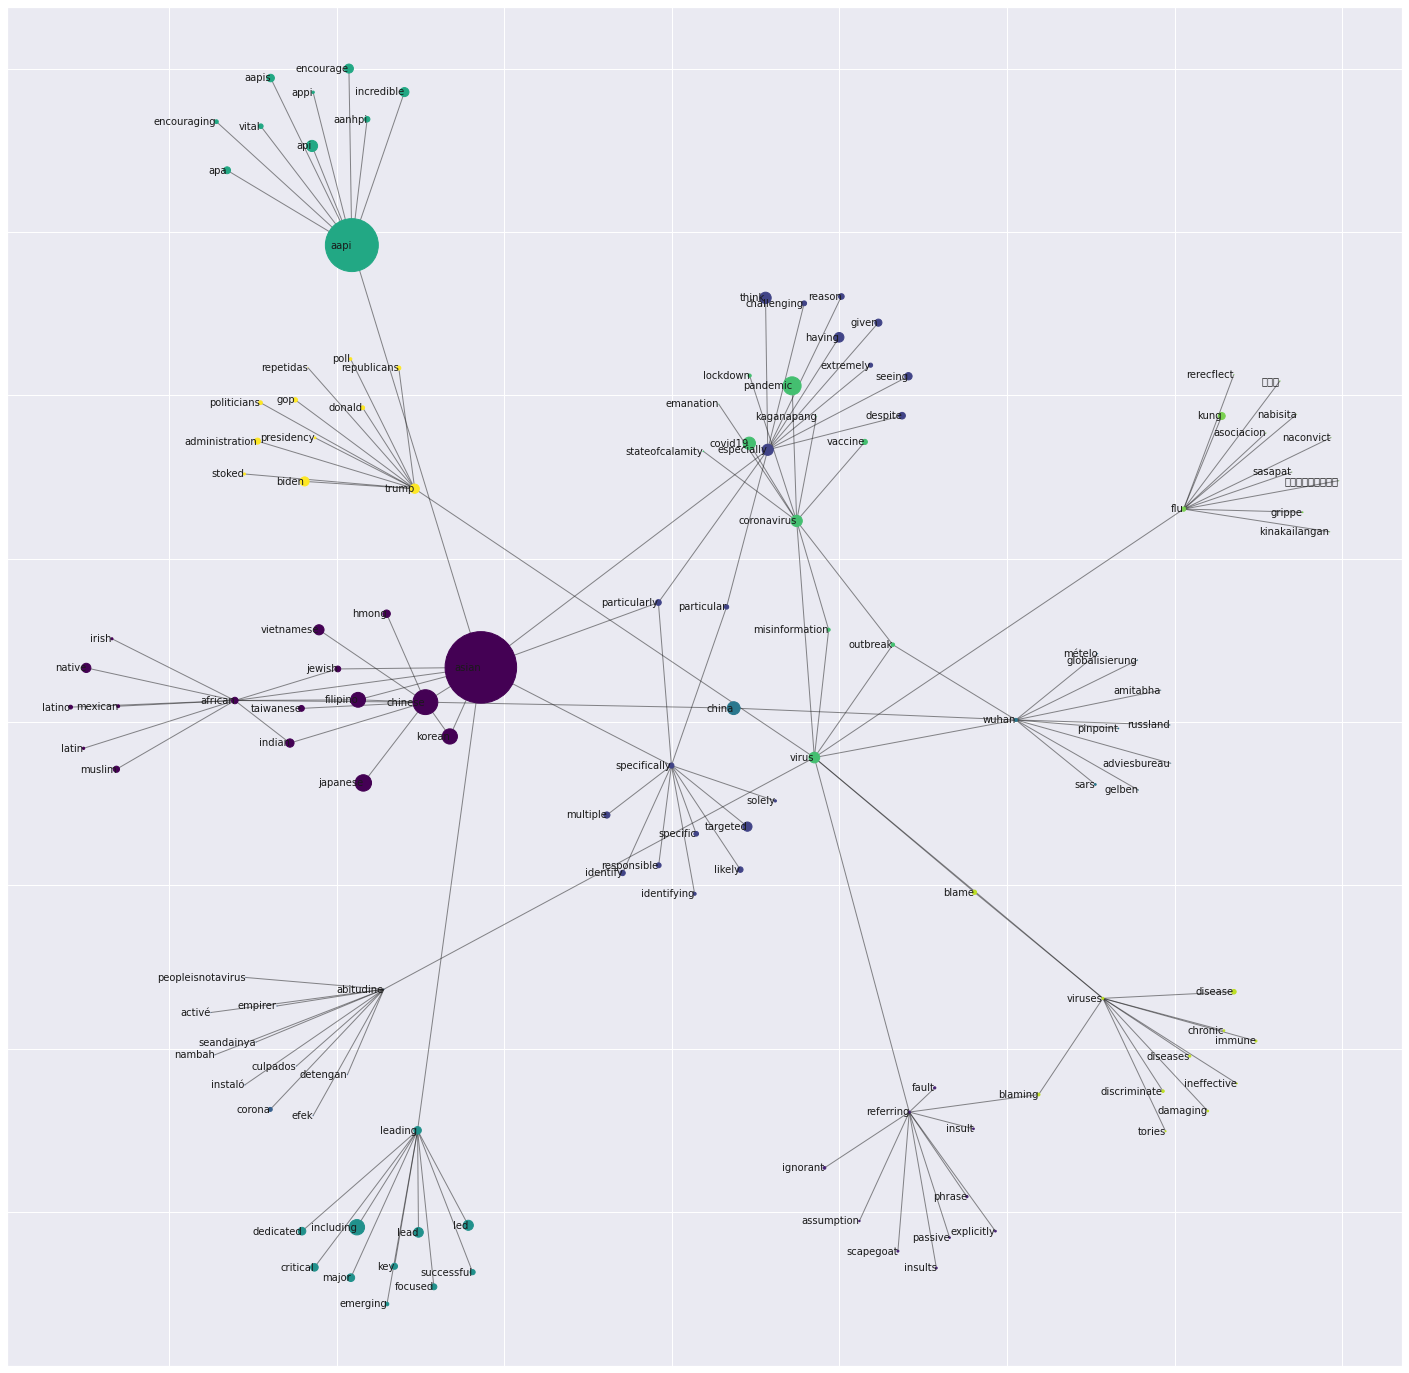

In [46]:
pos = nx.spring_layout(G)
plt.figure(figsize = (25,25))
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partitionLev2.values()) + 1)
nx.draw_networkx_nodes(G, pos, partitionLev2.keys(), node_size=[100*x for x in ns], cmap=cmap, node_color=list(partitionLev2.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, horizontalalignment="right")
plt.show()

In [47]:
# Topic modelling

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


data_words = []
for post in InstaPostList:
    try:
        text = post['message']
    except:
        try:
            text = post['description']
        except:
            continue 
    text = re.sub(r'http\S+', '', text)
    res = re.sub(r'[^\w\s]', ' ', text)
    res = remove_stopwords(res)
    data_word = simple_preprocess(res)
    data_word = [word for word in data_word if word not in stop_words]
    data_words.append(data_word)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mithundas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

In [49]:
from pprint import pprint
import warnings
# number of topics
num_topics = 10
# Build LDA model
warnings.simplefilter("ignore")
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics)

In [50]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.017*"asian" + 0.010*"aapi" + 0.010*"american" + 0.009*"stopasianhate" + '
  '0.008*"community" + 0.005*"stopaapihate" + 0.004*"support" + 0.004*"hate" + '
  '0.004*"americans" + 0.003*"violence"'),
 (1,
  '0.008*"aapi" + 0.007*"asian" + 0.004*"american" + 0.004*"new" + '
  '0.004*"hate" + 0.004*"support" + 0.003*"asianamerican" + 0.003*"community" '
  '+ 0.003*"history" + 0.003*"time"'),
 (2,
  '0.024*"asian" + 0.015*"aapi" + 0.009*"american" + 0.009*"community" + '
  '0.007*"hate" + 0.006*"stopasianhate" + 0.005*"asianamerican" + '
  '0.004*"pacific" + 0.004*"racism" + 0.004*"anti"'),
 (3,
  '0.013*"asian" + 0.010*"american" + 0.009*"aapi" + 0.008*"community" + '
  '0.006*"stopasianhate" + 0.004*"new" + 0.004*"hate" + 0.003*"stopaapihate" + '
  '0.003*"chinese" + 0.003*"pacific"'),
 (4,
  '0.015*"asian" + 0.009*"american" + 0.007*"aapi" + 0.007*"community" + '
  '0.006*"pacific" + 0.005*"month" + 0.004*"asianamerican" + 0.004*"new" + '
  '0.004*"stopasianhate" + 0.004*"herit

In [51]:
# Hashtag co-ocurrence analysis

currhashs = [k for (k,v) in all_hashtags.items() if v>200]

CorrCount = dict()
for hashtag in currhashs:
    CorrCount[hashtag] = dict()
    for hashtag2 in currhashs:
        if hashtag!=hashtag2:
            CorrCount[hashtag][hashtag2] = 0

In [52]:
hashtag_re = re.compile("#\w+ ")

for post in InstaPostList:
    try:
        line = post['message']
    except:
        try:
            line = post['description']
        except:
            continue 
    try:
        line = line.strip();
        line = line.lower();
    except:
        continue;
    tweet = line;
    hashtags = re.findall(hashtag_re,tweet);
    if(len(hashtags)>0):
        for hashtag in hashtags:
            hashorig = hashtag
            hashtag = hashtag.strip();
            if len(hashtag)<3:
                hashtags.remove(hashorig)
        for hashtag1 in hashtags:
            for hashtag2 in hashtags:
                hashtag1 = hashtag1.strip()
                hashtag2 = hashtag2.strip()
                if hashtag1!=hashtag2 and (hashtag1 in currhashs) and (hashtag2 in currhashs):
                    CorrCount[hashtag1][hashtag2] += 1

In [53]:
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

In [54]:
G = nx.Graph()

def makeGraph():
    for hashtag in currhashs:
        G.add_node(hashtag)
    for hashtag1 in currhashs:
        for hashtag2 in currhashs:
            if hashtag1!=hashtag2:
                if CorrCount[hashtag1][hashtag2]!=0:
                    weight = float(float(CorrCount[hashtag1][hashtag2]) / float(all_hashtags[hashtag1] * all_hashtags[hashtag2]))
                    G.add_edge(hashtag1, hashtag2, weight = weight)
    return

In [55]:
makeGraph()
G = G.to_undirected()
partitionLev2 = community_louvain.best_partition(G)

In [56]:
import statistics
import warnings

warnings.simplefilter("ignore")

ns = []
for node in G.nodes():
    ns.append(all_hashtags[node])
mns = statistics.mean(ns)
for i in range(len(ns)):
    ns[i] /= mns

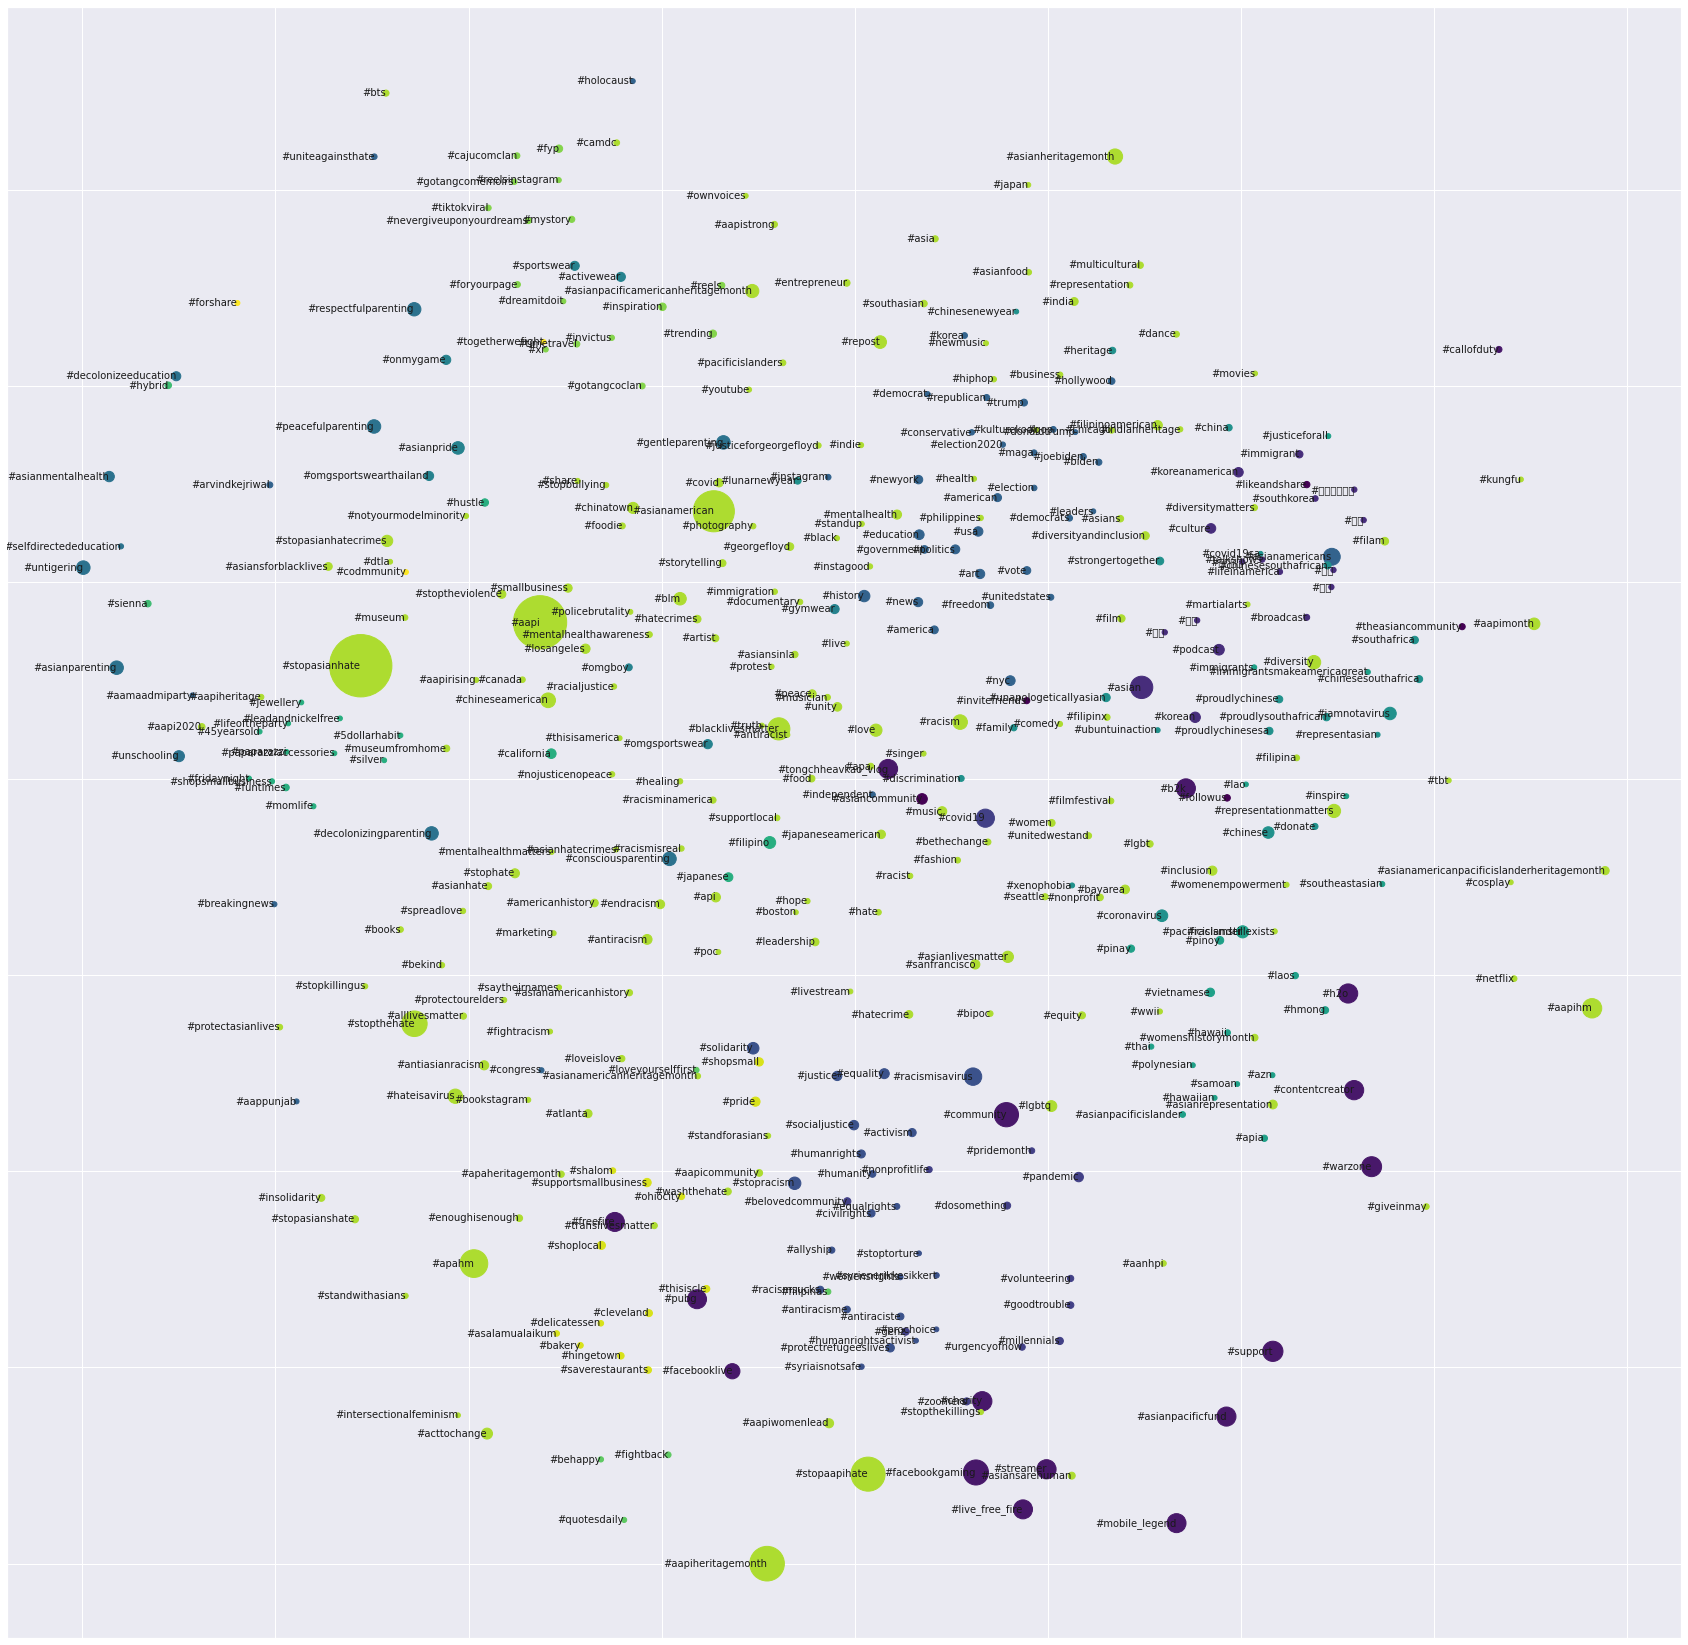

In [57]:
pos = nx.spring_layout(G)
plt.figure(figsize = (30,30))
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partitionLev2.values()) + 1)
nx.draw_networkx_nodes(G, pos, partitionLev2.keys(), node_size=[100*x for x in ns], cmap=cmap, node_color=list(partitionLev2.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, horizontalalignment="right")
plt.show()

In [58]:
# Post language analysis

languageCount = dict()

for post in InstaPostList:
    langCode = post["languageCode"]
    if langCode not in languageCount.keys():
        languageCount[langCode] = 0
    languageCount[langCode]+=1

In [59]:
languageCount = {k:v for k,v in sorted(languageCount.items(), key=lambda item:item[1], reverse=True)}

languageCount

{'en': 123307,
 'und': 40906,
 'th': 1591,
 'es': 1570,
 'tl': 1280,
 'zh': 1030,
 'vi': 613,
 'id': 534,
 'de': 532,
 'fr': 493,
 'hi': 354,
 'pt': 276,
 'my': 236,
 'ko': 229,
 'ja': 202,
 'it': 164,
 'ar': 152,
 'nl': 129,
 'ur': 112,
 'km': 87,
 'pa': 82,
 'te': 56,
 'da': 51,
 'bn': 41,
 'mn': 39,
 'el': 38,
 'tr': 37,
 'sv': 35,
 'ms': 32,
 'ne': 23,
 'ml': 22,
 'pl': 19,
 'ru': 18,
 'no': 17,
 'ta': 14,
 'lo': 13,
 'eo': 13,
 'gu': 9,
 'cs': 9,
 'fi': 9,
 'ro': 8,
 'uk': 8,
 'ha': 7,
 'ht': 7,
 'sq': 6,
 'kn': 6,
 'hr': 6,
 'hy': 6,
 'cx': 5,
 'jv': 5,
 'mr': 4,
 'he': 4,
 'az': 4,
 'sw': 4,
 'kk': 4,
 'sk': 3,
 'mg': 3,
 'bo': 3,
 'et': 2,
 'zu': 2,
 'si': 2,
 'as': 2,
 'lv': 2,
 'qh': 2,
 'bg': 2,
 'am': 2,
 'hu': 2,
 'fa': 1,
 'wo': 1,
 'tn': 1,
 'ig': 1,
 'or': 1,
 'ff': 1,
 'ak': 1,
 'ti': 1,
 'af': 1,
 'sn': 1,
 'lg': 1,
 'ca': 1,
 'ka': 1,
 'sd': 1,
 'mk': 1,
 'mt': 1,
 'so': 1,
 'xh': 1,
 'qi': 1}